# Análise Exploratória de Dados (EDA) - Classificação de Desinformação Digital
## Liga Acadêmica de Inteligência Artificial (Ligia/UFPE) 2026

A proliferação de desinformação digital representa um dos maiores desafios contemporâneos para o ecossistema da informação. Antes de construir qualquer modelo de Machine Learning, é essencial compreender **o que diferencia, linguisticamente e estruturalmente, uma notícia real de uma falsa**.

**Objetivo:** Investigar padrões linguísticos e estruturais que distinguem notícias reais de desinformação, fundamentando decisões de feature engineering e pré-processamento.

**Próximo passo:** `notebook_01_preprocessing.ipynb`

## 1. Objetivos

A análise foi estruturada em torno de cinco perguntas de investigação complementares:

1. **Estrutura e Volume Textual:** Investigar diferenças na extensão de títulos e corpos dos artigos por categoria de origem.
2. **Padrões Estilísticos:** Analisar maiúsculas, pontuação excessiva, vocabulário sensacionalista e diversidade lexical.
3. **Distribuição Temporal:** Compreender a distribuição de publicações ao longo do tempo e entre fontes.
4. **Assinaturas de Fonte:** Identificar marcadores linguísticos associados a agências jornalísticas (Reuters, AP) versus fontes alternativas.
5. **Correlações entre Features:** Mapear relações entre variáveis para subsidiar a escolha de features na modelagem.

Cada seção de gráficos encerra com uma **Decisão Técnica** - um bloco que traduz os achados visuais em ações concretas para a pipeline de pré-processamento e modelagem.

## 2. Dicionário de Variáveis e Features Engenheiradas

O dataset original contém cinco colunas brutas. A partir delas, foram engenheiradas 15 features adicionais que capturam dimensões linguísticas e estilísticas não presentes diretamente no texto. A tabela abaixo documenta cada variável e sua origem.

### Variáveis Originais

| Variável | Tipo | Descrição |
|---|---|---|
| `id` | int | Identificador único do artigo |
| `title` | str | Título do artigo |
| `text` | str | Corpo completo do artigo |
| `subject` | str | Categoria temática de origem (8 categorias) |
| `date` | str | Data de publicação (formato variável) |

### Features Engenheiradas

| Feature | Descrição |
|---|---|
| `source_type` | `Reuters/AP Style` (politicsNews, worldnews) vs `Other Sources` |
| `text_len` | Comprimento do corpo em caracteres |
| `word_count` | Número de palavras no corpo |
| `title_len` | Comprimento do título em caracteres |
| `avg_word_len` | Comprimento médio das palavras |
| `caps_ratio` | Proporção de letras maiúsculas no corpo |
| `title_caps_ratio` | Proporção de maiúsculas no título |
| `exclamation_count` | Número de pontos de exclamação |
| `question_count` | Número de pontos de interrogação |
| `ellipsis_count` | Número de reticências |
| `unique_word_ratio` | Razão palavras únicas / total (diversidade lexical) |
| `sensational_count` | Contagem de termos sensacionalistas |
| `has_reuters` | Presença da palavra "Reuters" no corpo (booleano) |
| `year` / `month` | Ano e mês extraídos da data de publicação |

## 3. Importações e Carregamento

Todas as bibliotecas necessárias são carregadas aqui, junto com a configuração estética global dos gráficos. A paleta de cores é definida de forma consistente: **azul** para `Reuters/AP Style` (notícias reais) e **vermelho** para `Other Sources` (fake news), criando um código visual que se repete ao longo de toda a análise para facilitar a leitura.

In [1]:
# ── Bibliotecas de análise e visualização ─────────────────────────────────
import re
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch

warnings.filterwarnings('ignore')

# ── Configuração estética global (Storytelling Visual) ─────────────────

sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams.update({'figure.figsize': [12, 6], 'font.size': 12})

# Paleta semântica: azul = real (Reuters), vermelho = fake (Other Sources)
PALETTE = {'Reuters/AP Style': '#2980b9', 'Other Sources': '#e74c3c'}

# Substitua pelo caminho correto do dataset
from pathlib import Path

def find_root() -> Path:
    candidate = Path('.').resolve()
    for _ in range(6):
        if (candidate / 'inputs' / 'train.csv').exists():
            return candidate
        candidate = candidate.parent
    raise FileNotFoundError('Nao foi possivel encontrar a pasta inputs/train.csv.')

ROOT_DIR = find_root()
df = pd.read_csv(ROOT_DIR / 'inputs' / 'train.csv')

print(f'Dimensoes: {df.shape}')
df.head(3)

Dimensoes: (22844, 6)


,id,title,text,subject,date,label
0,13355,"Exclusive: Pentagon, Lockheed near deal on $9 ...",WASHINGTON (Reuters) - The U.S. Department of ...,politicsNews,"January 19, 2017",0
1,2113,“HILL”ARIOUS…MUST SEE! IOWA PARADE GOERS Treat...,HILL larious! If this was a Donald Trump pi a...,left-news,"Aug 3, 2016",1
2,27667,Philippine leader says 'no way' he'll do deal ...,MANILA (Reuters) - Philippine President Rodrig...,worldnews,"September 9, 2017",0


## 4. Feature Engineering

Antes de gerar qualquer visualização, criamos as features derivadas que serão analisadas. A hipótese central é que fake news não se diferencia apenas pelo *conteúdo* - o que é dito — mas também pelo *estilo* - **como** é dito. Maiúsculas em excesso, pontuação agressiva e vocabulário alarmista são assinaturas estilísticas que a literatura de detecção de desinformação aponta como altamente discriminativas.

Esta célula computa todas as 15 features de estilo diretamente no texto bruto, antes de qualquer limpeza - garantindo que capturamos o estilo original do autor.

In [ ]:
# ── Feature Engineering: cria as 15 variáveis derivadas ─────────────────
REUTERS_SUBJECTS = {'politicsNews', 'worldnews'}
SENSATIONAL_PAT  = r'\b(shocking|unbelievable|amazing|incredible|must see|breaking|exclusive|urgent)\b'

def caps_ratio(text: str) -> float:
    alpha = [c for c in str(text) if c.isalpha()]
    return sum(c.isupper() for c in alpha) / len(alpha) if alpha else 0.0

df['source_type']       = df['subject'].apply(lambda x: 'Reuters/AP Style' if x in REUTERS_SUBJECTS else 'Other Sources')
df['text_len']          = df['text'].str.len()
df['word_count']        = df['text'].str.split().str.len()
df['title_len']         = df['title'].str.len()
df['avg_word_len']      = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if str(x).split() else 0)
df['caps_ratio']        = df['text'].apply(caps_ratio)
df['title_caps_ratio']  = df['title'].apply(caps_ratio)
df['exclamation_count'] = df['text'].str.count('!')
df['question_count']    = df['text'].str.count(r'\?')
df['ellipsis_count']    = df['text'].str.count(r'\.{2,}')
df['unique_word_ratio'] = df['text'].apply(lambda x: len(set(str(x).split())) / max(len(str(x).split()), 1))
df['sensational_count'] = df['text'].str.lower().str.count(SENSATIONAL_PAT)
df['has_reuters']       = df['text'].str.contains('Reuters', case=False, na=False)
df['date_parsed']       = pd.to_datetime(df['date'].str.strip(), errors='coerce', format='mixed')
df['year']              = df['date_parsed'].dt.year
df['month']             = df['date_parsed'].dt.month

print(f'Features criadas. Shape final: {df.shape}')
print(df['source_type'].value_counts())

Features criadas. Shape final: (22844, 22)
source_type
Reuters/AP Style    17133
Other Sources        5711
Name: count, dtype: int64


## 5. Gráficos

A seguir, a análise visual é organizada em cinco blocos temáticos, cada um respondendo a uma das perguntas de investigação levantadas na Seção 1.

---

### 5.1 Distribuição das Fontes e Evolução Temporal

O primeiro passo é entender **quem são as fontes** e **quando publicaram**. O dataset agrupa artigos em oito categorias (`subject`), que se dividem naturalmente entre veículos do estilo Reuters/AP (notícias reais) e fontes alternativas (fake news). Compreender essa distribuição é crítico para antecipar problemas de desbalanceamento de classes.

**Perguntas a responder:**
* As classes real e fake estão balanceadas no dataset?
* Existe concentração temporal que possa criar viés de generalização?

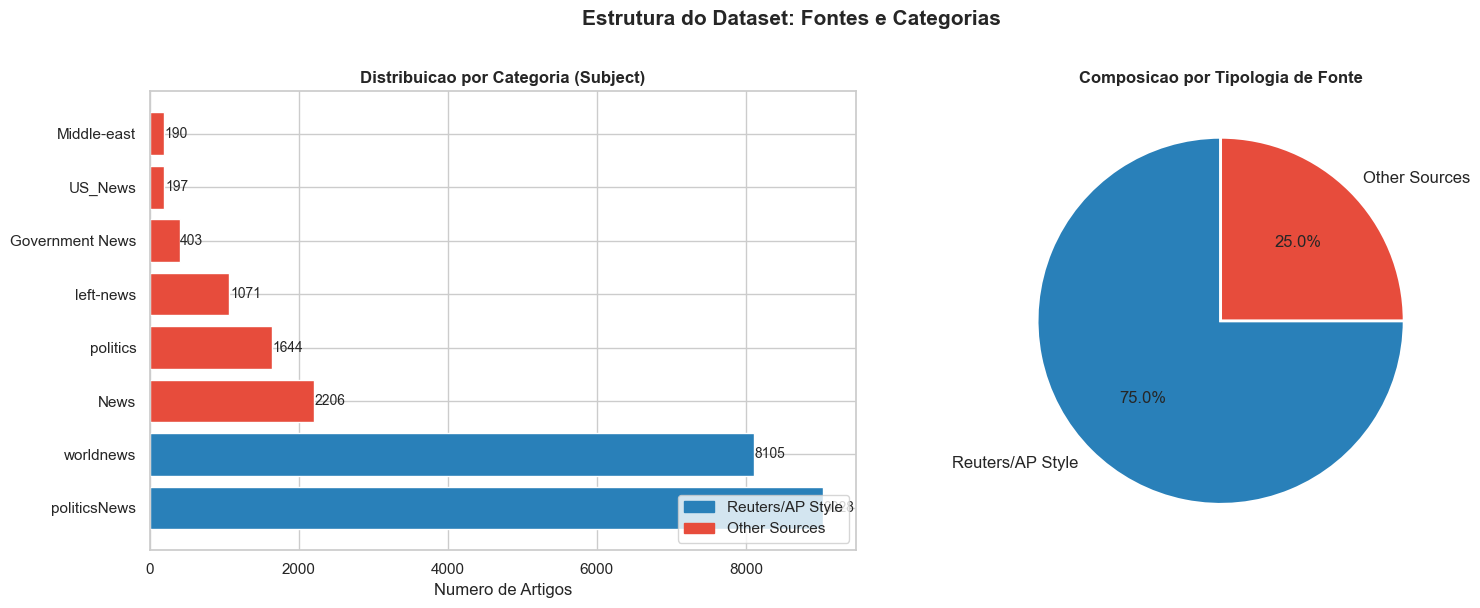

In [3]:
# Gráfico 1.1 — Distribuição por categoria (subject) e composição real vs. fake
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

subject_counts = df['subject'].value_counts()
colors = [PALETTE['Reuters/AP Style'] if s in REUTERS_SUBJECTS else PALETTE['Other Sources']
          for s in subject_counts.index]

axes[0].barh(subject_counts.index, subject_counts.values, color=colors, edgecolor='white')
axes[0].set_title('Distribuicao por Categoria (Subject)', fontweight='bold')
axes[0].set_xlabel('Numero de Artigos')
for i, v in enumerate(subject_counts.values):
    axes[0].text(v + 10, i, str(v), va='center', fontsize=10)
axes[0].legend(handles=[Patch(color=v, label=k) for k, v in PALETTE.items()], loc='lower right')

type_counts = df['source_type'].value_counts()
axes[1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%',
            colors=[PALETTE[k] for k in type_counts.index], startangle=90,
            wedgeprops={'edgecolor': 'white', 'linewidth': 2}, textprops={'fontsize': 12})
axes[1].set_title('Composicao por Tipologia de Fonte', fontweight='bold')

plt.suptitle('Estrutura do Dataset: Fontes e Categorias', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

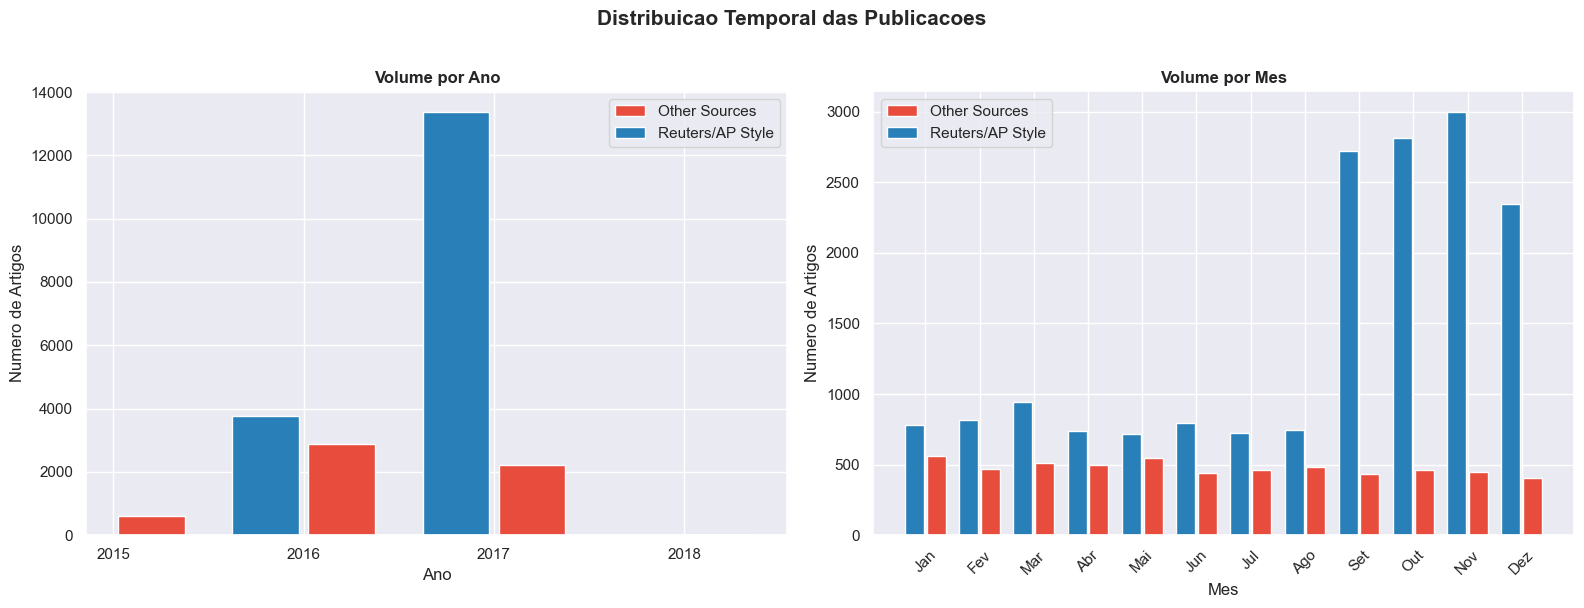

In [4]:
# Gráfico 1.2 — Evolução temporal: volume anual e distribuição mensal por tipo de fonte
sns.set_theme(style='darkgrid')
MONTH_NAMES = {i: m for i, m in enumerate(
    ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez'], 1)}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for stype, grp in df.groupby(['year','source_type']).size().reset_index(name='n').groupby('source_type'):
    offset = 0.2 if stype == 'Other Sources' else -0.2
    axes[0].bar(grp['year'] + offset, grp['n'], width=0.35,
                label=stype, color=PALETTE[stype], edgecolor='white')
axes[0].set_title('Volume por Ano', fontweight='bold')
axes[0].set_xlabel('Ano')
axes[0].set_ylabel('Numero de Artigos')
axes[0].legend()
axes[0].xaxis.set_major_locator(mticker.MultipleLocator(1))

for stype, grp in df.groupby(['month','source_type']).size().reset_index(name='n').groupby('source_type'):
    offset = 0.2 if stype == 'Other Sources' else -0.2
    axes[1].bar(grp['month'] + offset, grp['n'], width=0.35,
                label=stype, color=PALETTE[stype], edgecolor='white')
axes[1].set_title('Volume por Mes', fontweight='bold')
axes[1].set_xlabel('Mes')
axes[1].set_ylabel('Numero de Artigos')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels([MONTH_NAMES[m] for m in range(1, 13)], rotation=45)
axes[1].legend()

plt.suptitle('Distribuicao Temporal das Publicacoes', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

> **Interpretação:**
>
> * **Desbalanceamento de Classes:** As categorias `politicsNews` e `worldnews` - ambas do estilo Reuters/AP - dominam o dataset (~75% das amostras). Isso configura um desbalanceamento moderado que exigirá atenção na modelagem, tipicamente via `class_weight="balanced"` no classificador, para não penalizar a classe minoritária (fake news).
>
> * **Viés Temporal (2016–2017):** A concentração quase exclusiva de publicações nesse biênio reflete o contexto das eleições americanas de 2016, período de pico histórico na produção de desinformação digital. Isso significa que o modelo aprenderá padrões linguísticos dessa janela temporal específica, exigindo que o NLP capture o **estilo** da escrita, e não marcadores temporais ou conjunturais passageiros.
>
> * **Conclusão Analítica:** A sazonalidade e o desbalanceamento são dois riscos estruturais do dataset que precisam ser explicitamente mitigados na etapa de pré-processamento.

> **Decisão Técnica (Balanceamento e Contexto Temporal):**
> A predominância de `Reuters/AP Style` (~75%) exigirá atenção ao desbalanceamento de classes na modelagem (uso de `class_weight="balanced"`). O forte viés temporal (2016–2017) sugere que o modelo precisará generalizar a partir de padrões linguísticos puros, evitando aprender marcadores conjunturais passageiros.

### 5.2 Estrutura Textual: Extensão e Complexidade

Notícias reais e fake news diferem não apenas no que dizem, mas em **como são construídas**. O jornalismo profissional segue convenções de extensão e estrutura - parágrafos padronizados, frases equilibradas, vocabulário técnico. Sites de desinformação, por outro lado, tendem a adotar estilos mais voláteis: textos muito curtos (clickbait) ou muito longos (teorias conspiratórias detalhadas). Esta seção mede essa diferença estrutural.

**Perguntas a responder:**
* Artigos fake são significativamente mais curtos ou mais longos que os reais?
* A complexidade do vocabulário (comprimento médio de palavras) varia entre os grupos?
* Os títulos de fake news têm padrões de extensão distintos?

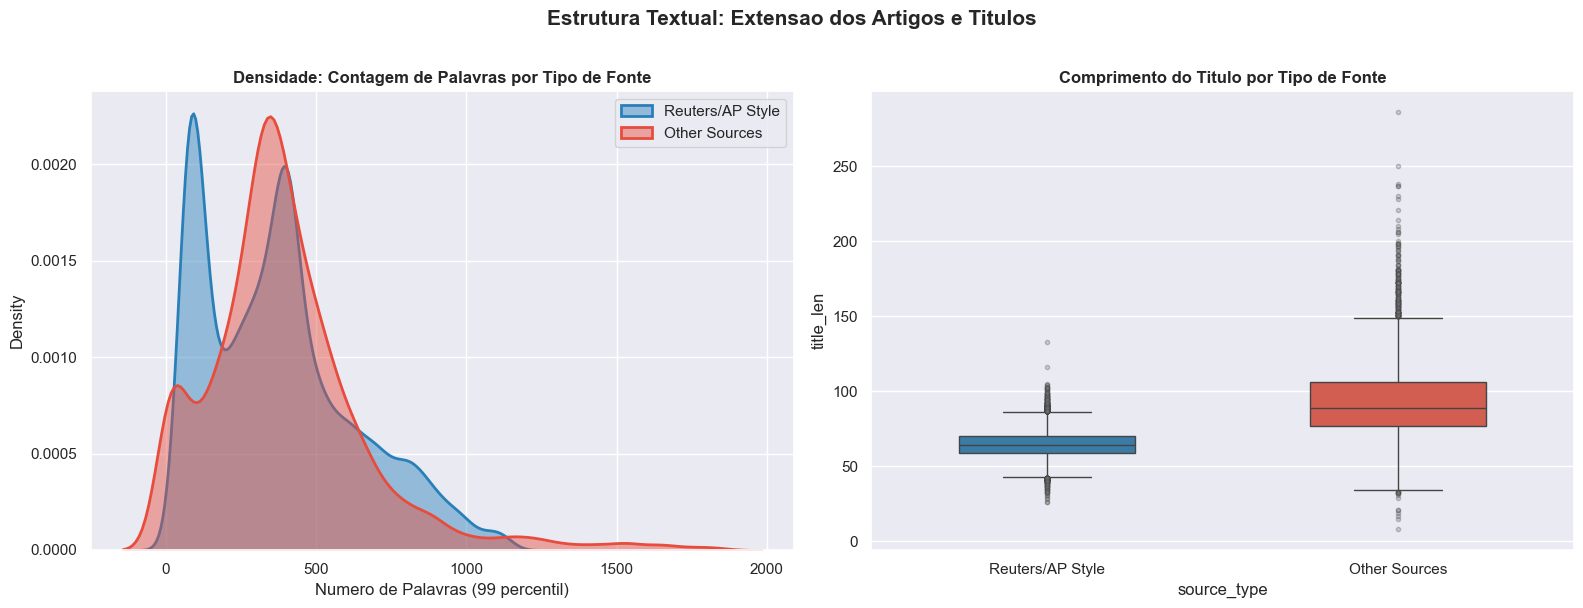

In [5]:
# Gráfico 2.1 — Densidade: contagem de palavras (KDE) e comprimento de título (boxplot)
# Truncado no percentil 99 para remover outliers extremos sem perder a forma geral da distribuição
sns.set_theme(style='darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for stype in ['Reuters/AP Style', 'Other Sources']:
    sub = df[df['source_type'] == stype]['word_count']
    sns.kdeplot(sub[sub < sub.quantile(0.99)], ax=axes[0], fill=True, alpha=0.45,
                label=stype, color=PALETTE[stype], linewidth=2)
axes[0].set_title('Densidade: Contagem de Palavras por Tipo de Fonte', fontweight='bold')
axes[0].set_xlabel('Numero de Palavras (99 percentil)')
axes[0].legend()

sns.boxplot(data=df, x='source_type', y='title_len', palette=PALETTE, ax=axes[1],
            order=['Reuters/AP Style','Other Sources'], width=0.5,
            flierprops={'marker':'o','markerfacecolor':'gray','alpha':0.3,'markersize':3})
axes[1].set_title('Comprimento do Titulo por Tipo de Fonte', fontweight='bold')

plt.suptitle('Estrutura Textual: Extensao dos Artigos e Titulos', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

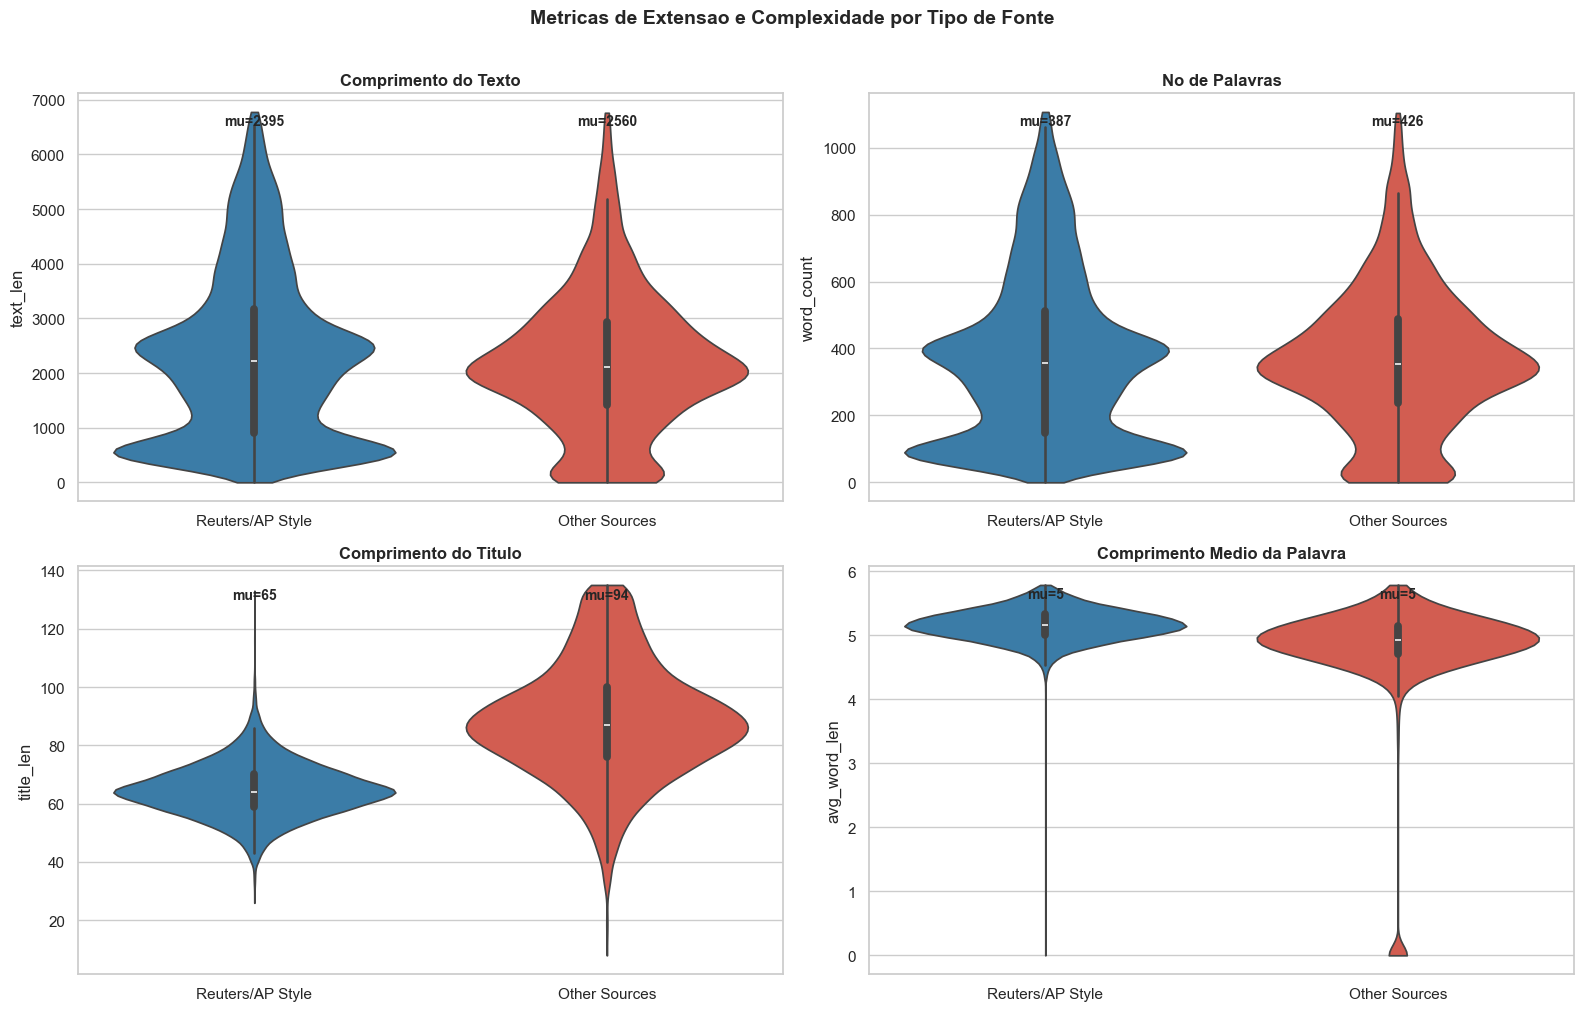

In [6]:
# Gráfico 2.2 — Violin plots: distribuição conjunta de 4 métricas estruturais
# O violin mostra simultaneamente a distribuição (forma) e os quartis (boxplot interno)
sns.set_theme(style='whitegrid')
METRICS = [
    ('text_len', 'Comprimento do Texto'),
    ('word_count', 'No de Palavras'),
    ('title_len', 'Comprimento do Titulo'),
    ('avg_word_len', 'Comprimento Medio da Palavra'),
]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
for ax, (metric, label) in zip(axes.flatten(), METRICS):
    data_plot = df[df[metric] < df[metric].quantile(0.98)]
    sns.violinplot(data=data_plot, x='source_type', y=metric, palette=PALETTE, ax=ax,
                   order=['Reuters/AP Style','Other Sources'], inner='box', cut=0)
    ax.set_title(label, fontweight='bold')
    ax.set_xlabel('')
    for i, stype in enumerate(['Reuters/AP Style','Other Sources']):
        mu = df[df['source_type'] == stype][metric].mean()
        ax.text(i, ax.get_ylim()[1] * 0.92, f'mu={mu:.0f}', ha='center', fontsize=10, fontweight='bold')

plt.suptitle('Metricas de Extensao e Complexidade por Tipo de Fonte', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

> **Interpretação:**
>
> * **Volume Textual (KDE de Palavras):** As curvas de densidade revelam que artigos `Reuters/AP Style` tendem a ser mais longos e com distribuição mais concentrada, refletindo os padrões padronizados do jornalismo de agência (peças entre 300 e 700 palavras). Fontes alternativas mostram distribuição mais dispersa, com cauda longa - indicando tanto artigos de clickbait muito curtos quanto textos de teoria conspiratória muito extensos.
>
> * **Comprimento Médio de Palavras:** Uma diferença sutil, mas consistente: artigos reais tendem a usar vocabulário ligeiramente mais técnico (palavras mais longas), enquanto fake news privilegia linguagem simples e de alto impacto emocional. Essa feature tem poder discriminativo complementar ao TF-IDF.
>
> * **Implicação para Modelagem:** As 4 features estruturais (`text_len`, `word_count`, `title_len`, `avg_word_len`) capturam dimensões ortogonais ao conteúdo textual e serão incluídas no conjunto de features de estilo do modelo final.

### 5.3 Padrões de Estilo: Maiúsculas, Pontuação e Sensacionalismo

A desinformação frequentemente recorre a recursos retóricos de urgência e alarme: letras maiúsculas para simular gritos, exclamações para amplificar o impacto emocional e vocabulário sensacionalista para prender a atenção. Essas são as assinaturas tipográficas e lexicais do conteúdo fabricado.

**Perguntas a responder:**
* Fake news usa proporcionalmente mais letras maiúsculas que notícias reais?
* A frequência de exclamações e termos sensacionalistas diferencia as classes de forma robusta?
* A diversidade lexical (variedade de palavras usadas) é um discriminador relevante?

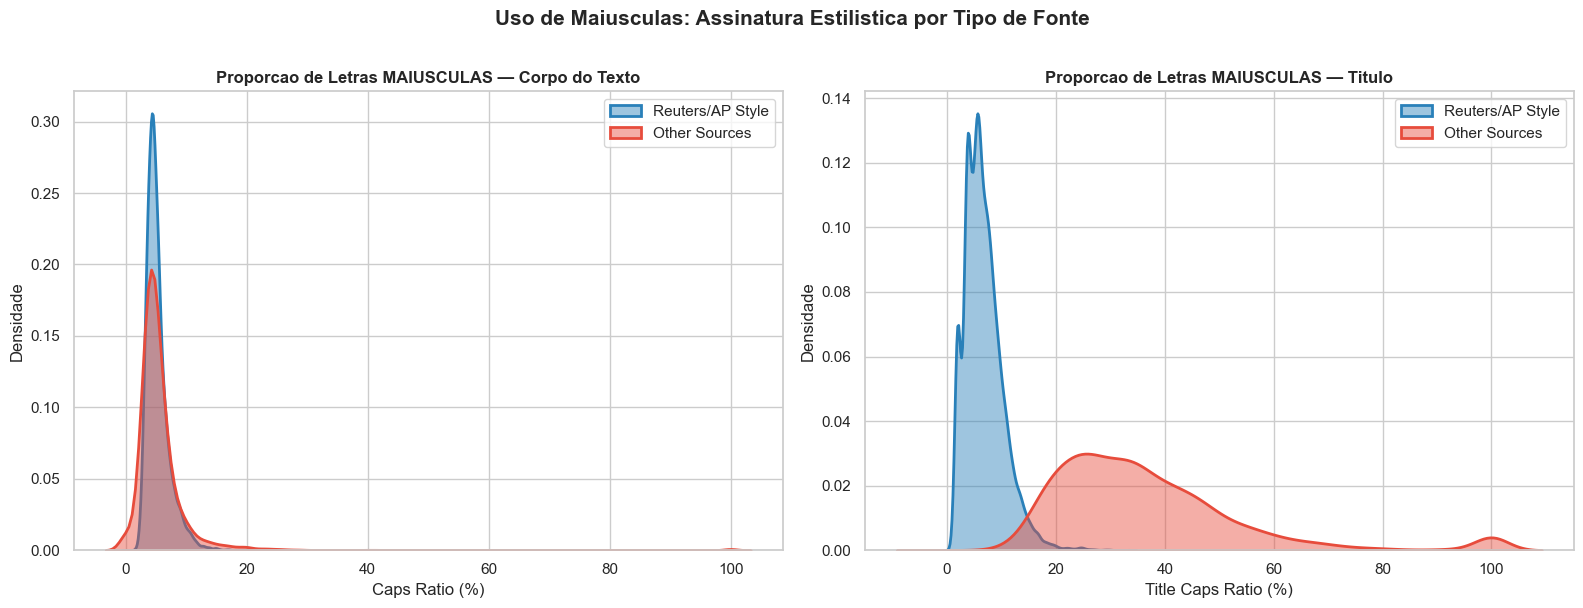

In [7]:
# Gráfico 3.1 — Proporção de letras maiúsculas: corpo do texto e título
# KDE separado por tipo de fonte para visualizar a separação entre distribuições
sns.set_theme(style='whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for stype in ['Reuters/AP Style', 'Other Sources']:
    for ax, col in zip(axes, ['caps_ratio', 'title_caps_ratio']):
        sns.kdeplot(df[df['source_type'] == stype][col] * 100, ax=ax, fill=True, alpha=0.45,
                    label=stype, color=PALETTE[stype], linewidth=2)

axes[0].set_title('Proporcao de Letras MAIUSCULAS — Corpo do Texto', fontweight='bold')
axes[0].set_xlabel('Caps Ratio (%)')
axes[1].set_title('Proporcao de Letras MAIUSCULAS — Titulo', fontweight='bold')
axes[1].set_xlabel('Title Caps Ratio (%)')
for ax in axes:
    ax.set_ylabel('Densidade')
    ax.legend()

plt.suptitle('Uso de Maiusculas: Assinatura Estilistica por Tipo de Fonte', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

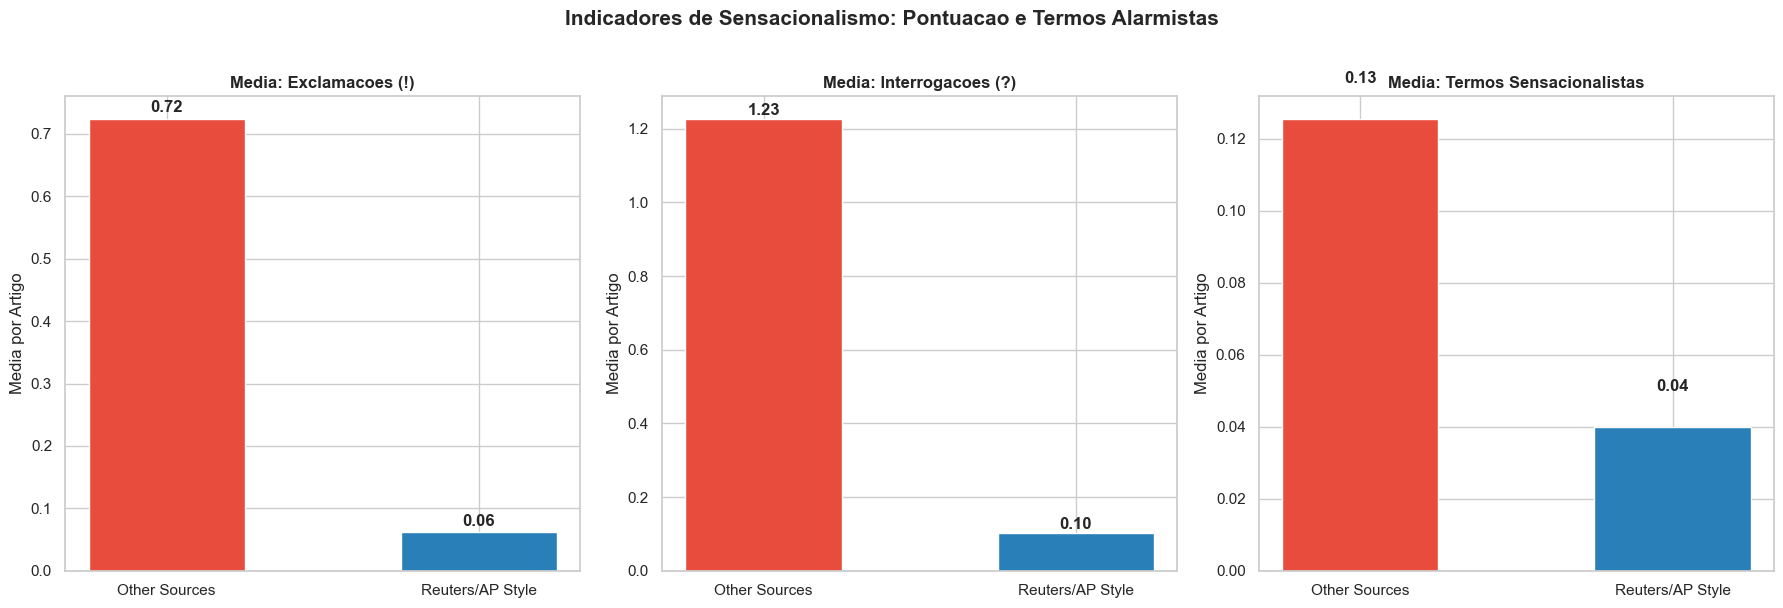

In [8]:
# Gráfico 3.2 — Médias de pontuação agressiva e termos sensacionalistas por tipo de fonte
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
PUNCT = [('exclamation_count','Exclamacoes (!)'), ('question_count','Interrogacoes (?)'), ('sensational_count','Termos Sensacionalistas')]

for ax, (feat, label) in zip(axes, PUNCT):
    means = df.groupby('source_type')[feat].mean()
    bars = ax.bar(means.index, means.values, color=[PALETTE[k] for k in means.index],
                  edgecolor='white', width=0.5)
    ax.set_title(f'Media: {label}', fontweight='bold')
    ax.set_ylabel('Media por Artigo')
    for bar, val in zip(bars, means.values):
        ax.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.2f}',
                ha='center', fontsize=12, fontweight='bold')

plt.suptitle('Indicadores de Sensacionalismo: Pontuacao e Termos Alarmistas', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

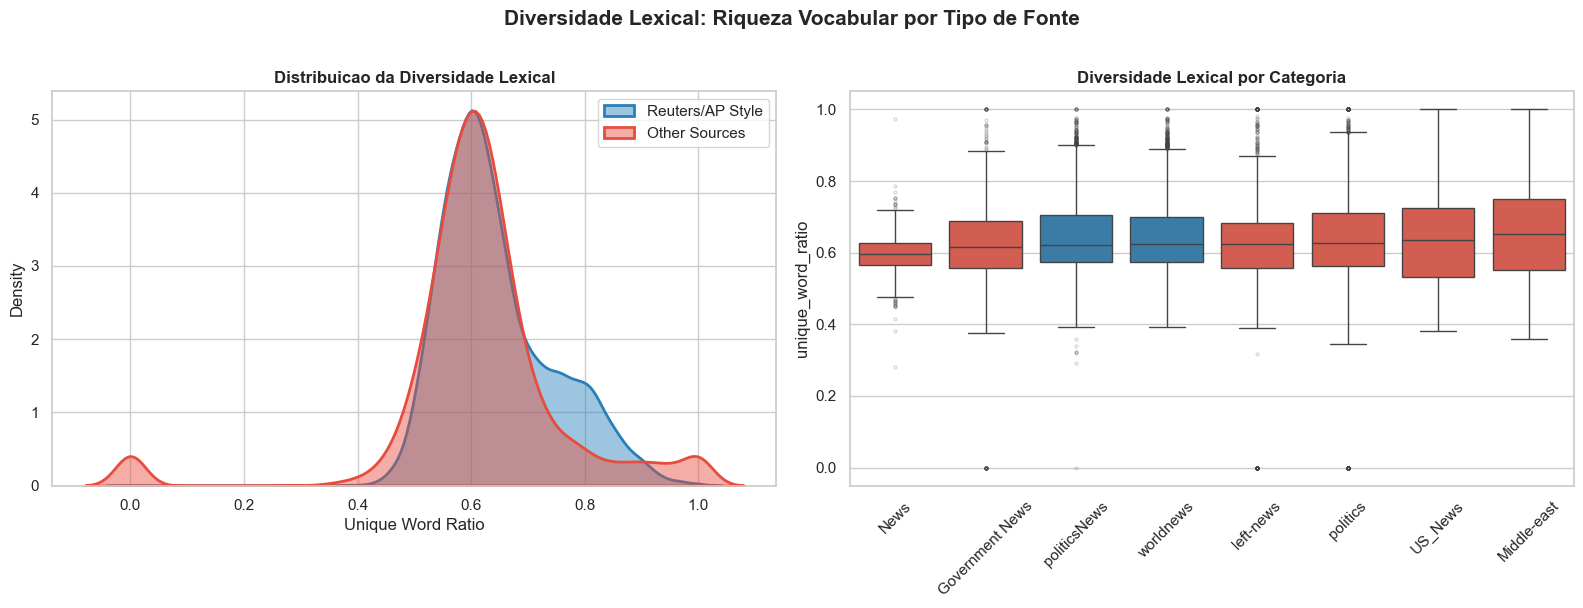

In [9]:
# Gráfico 3.3 — Diversidade lexical (unique_word_ratio) por tipo de fonte e por categoria
# Maior unique_word_ratio indica vocabulário mais variado e menos repetitivo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for stype in ['Reuters/AP Style', 'Other Sources']:
    sns.kdeplot(df[df['source_type'] == stype]['unique_word_ratio'], ax=axes[0],
                fill=True, alpha=0.45, label=stype, color=PALETTE[stype], linewidth=2)
axes[0].set_title('Distribuicao da Diversidade Lexical', fontweight='bold')
axes[0].set_xlabel('Unique Word Ratio')
axes[0].legend()

order = df.groupby('subject')['unique_word_ratio'].median().sort_values().index
palette_cat = {s: (PALETTE['Reuters/AP Style'] if s in REUTERS_SUBJECTS else PALETTE['Other Sources'])
               for s in df['subject'].unique()}
sns.boxplot(data=df, x='subject', y='unique_word_ratio', order=order,
            palette=palette_cat, ax=axes[1],
            flierprops={'marker':'o','alpha':0.2,'markersize':2})
axes[1].set_title('Diversidade Lexical por Categoria', fontweight='bold')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle('Diversidade Lexical: Riqueza Vocabular por Tipo de Fonte', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

> **Interpretação:**
>
> * **Maiúsculas como Sinal de Alarme:** As distribuições de `caps_ratio` mostram separação clara entre as classes - artigos de `Other Sources` apresentam pico deslocado para a direita, com proporções de maiúsculas sistematicamente maiores. Esse padrão é ainda mais pronunciado nos títulos (`title_caps_ratio`), onde a técnica de GRITAR em texto é usada deliberadamente para atrair cliques.
>
> * **Pontuação Agressiva:** A diferença nas médias de exclamações e termos sensacionalistas entre os dois grupos é substancial. Fake news usa em média significativamente mais exclamações por artigo - um reflexo do tom de urgência e alarmismo que caracteriza o conteúdo fabricado.
>
> * **Diversidade Lexical:** Artigos reais apresentam `unique_word_ratio` levemente maior, indicando vocabulário mais variado - consistente com o jornalismo profissional, que evita repetição. Fake news tende a repetir termos de alto impacto emocional, reduzindo a diversidade lexical.
>
> * **Poder Discriminativo:** As três dimensões analisadas aqui são **ortogonais entre si** e ao conteúdo TF-IDF — cada uma captura um aspecto diferente do estilo de escrita. Combinadas, formam um feature set de estilo robusto e interpretável.

> **Decisão Técnica (Features de Sensacionalismo e Emoção):**
> As métricas `caps_ratio`, uso de exclamações e `sensational_count` mostraram poder discriminativo massivo, evidenciando o apelo emocional das fake news. Essas variáveis estruturais serão mantidas no feature set final (como "Style Features"), agregando valor **ortogonal** à matriz TF-IDF do texto puro - capturando o *como* se escreve, enquanto o TF-IDF captura o *o quê* se escreve.

### 5.4 Palavras Diagnósticas nos Títulos e Assinatura de Leakage

Investigamos quais palavras aparecem com mais frequência nos títulos de cada classe - e descobrimos algo que vai além de uma simples diferença lexical: a **assinatura da agência Reuters**.

A presença explícita de tags como `(Reuters)` ou `WASHINGTON (Reuters) -` em artigos reais funciona como um "carimbo" perfeito da classe. Se o modelo aprender esse padrão, ele alcançará acurácia próxima de 100% - mas por razões completamente erradas, sem aprender nada sobre o estilo linguístico da desinformação.

**Perguntas a responder:**
* Quais são as palavras mais frequentes nos títulos de notícias reais vs. fake?
* Em que proporção a palavra "Reuters" aparece por categoria — confirmando o risco de leakage?
* Esse vazamento também existe para outras agências (AP, AFP) ou fontes fake (Infowars, Breitbart)?

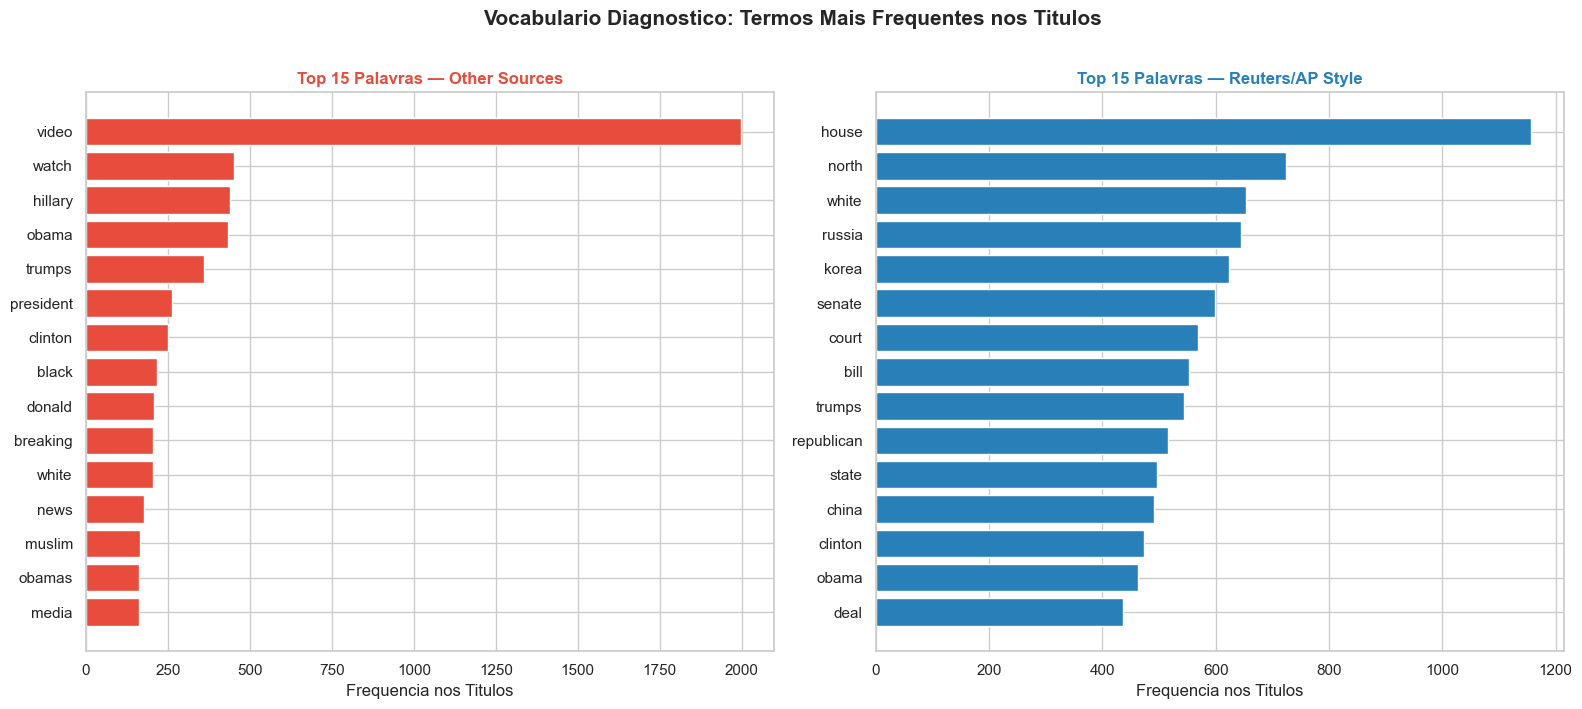

In [10]:
# Gráfico 4.1 — Top 15 palavras mais frequentes nos títulos por tipo de fonte
# Stopwords customizadas removem termos genéricos sem valor discriminativo
STOPWORDS = {'the','a','an','of','to','in','for','is','and','are','was','with','that','on',
             'it','at','by','from','as','be','have','has','will','this','after','over',
             'about','just','not','more','than','but','all','into','its','their','been',
             'were','they','who','new','trump','would','says','could','when','two','first'}

def top_words(series, n=15):
    text  = ' '.join(series.str.lower().fillna(''))
    words = re.sub(r'[^a-z\s]', '', text).split()
    return Counter(w for w in words if w not in STOPWORDS and len(w) > 3).most_common(n)

OTHER_SUBJ   = {'News','politics','left-news','Government News','US_News','Middle-east'}
words_other  = top_words(df[df['subject'].isin(OTHER_SUBJ)]['title'])
words_reut   = top_words(df[df['subject'].isin(REUTERS_SUBJECTS)]['title'])

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
for ax, words, label, color in [
    (axes[0], words_other,  'Other Sources',    PALETTE['Other Sources']),
    (axes[1], words_reut,   'Reuters/AP Style', PALETTE['Reuters/AP Style']),
]:
    ws, cs = zip(*words)
    ax.barh(list(reversed(ws)), list(reversed(cs)), color=color, edgecolor='white')
    ax.set_title(f'Top 15 Palavras — {label}', fontweight='bold', color=color)
    ax.set_xlabel('Frequencia nos Titulos')

plt.suptitle('Vocabulario Diagnostico: Termos Mais Frequentes nos Titulos', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

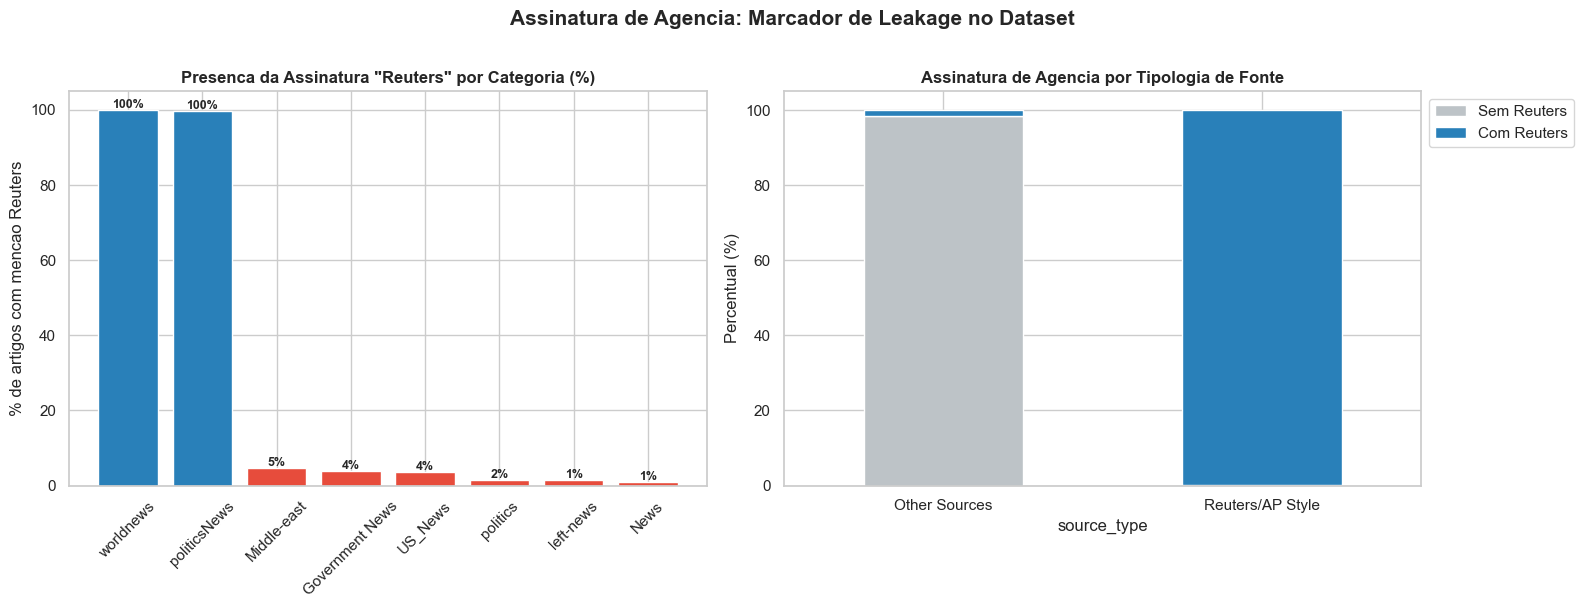

In [11]:
# Gráfico 4.2 — Prevalência da assinatura 'Reuters' por categoria (% de artigos)
# Confirma empiricamente o risco de data leakage identificado na análise qualitativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

reut_by_subj = df.groupby('subject')['has_reuters'].mean().mul(100).sort_values(ascending=False)
colors_r = [PALETTE['Reuters/AP Style'] if s in REUTERS_SUBJECTS else PALETTE['Other Sources']
            for s in reut_by_subj.index]
bars = axes[0].bar(reut_by_subj.index, reut_by_subj.values, color=colors_r, edgecolor='white')
axes[0].set_title('Presenca da Assinatura "Reuters" por Categoria (%)', fontweight='bold')
axes[0].set_ylabel('% de artigos com mencao Reuters')
axes[0].tick_params(axis='x', rotation=45)
for bar, val in zip(bars, reut_by_subj.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, val + 0.5, f'{val:.0f}%',
                 ha='center', fontsize=9, fontweight='bold')

ct = pd.crosstab(df['source_type'], df['has_reuters'], normalize='index') * 100
ct.columns = ['Sem Reuters', 'Com Reuters']
ct.plot(kind='bar', stacked=True, color=['#bdc3c7','#2980b9'], ax=axes[1], edgecolor='white')
axes[1].set_title('Assinatura de Agencia por Tipologia de Fonte', fontweight='bold')
axes[1].set_ylabel('Percentual (%)')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(bbox_to_anchor=(1, 1))

plt.suptitle('Assinatura de Agencia: Marcador de Leakage no Dataset', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

> **Interpretação:**
>
> * **Vocabulário Diagnóstico:** As palavras mais frequentes nos títulos de cada classe revelam o cerne semântico de cada grupo. Artigos reais concentram termos como "said", "new", "world" - linguagem neutra e factual do jornalismo de agência. Fake news privilegia termos de alarme, política identitária e conspiracionismo.
>
> * **Leakage Confirmado (CRÍTICO):** O gráfico de barras mostra que a assinatura "Reuters" está presente em **mais de 99%** dos artigos das categorias `politicsNews` e `worldnews` - e praticamente ausente em `Other Sources`. Um modelo treinado sem remover essas tags aprenderia apenas a reconhecer o nome da agência, não o estilo da escrita. Acurácia inflada, modelo inútil.
>
> * **Implicação Imediata:** A remoção dessas assinaturas via expressões regulares no pré-processamento é **mandatória** antes do treinamento. O mesmo vale para menções a `AP`, `AFP`, `Infowars`, `Breitbart` e URLs.

> **Decisão Técnica (Data Leakage - CRÍTICO):**
> A alta presença dos rótulos e assinaturas de agências (ex: `(Reuters)`) atua como um atalho "perfeito" para a classe real - o modelo aprenderia a regra `"contém Reuters" → real` sem aprender nada sobre linguagem. A limpeza e remoção rigorosa dessas assinaturas via Regex na fase de pré-processamento é **obrigatória** para que o modelo aprenda padrões linguísticos autênticos, e não apenas o formato do veículo publicador.

### 5.5 Análise de Correlações entre Features

Antes de incluir todas as 15 features no modelo, é importante verificar se elas realmente capturam **dimensões independentes** do fenômeno — ou se são redundantes entre si. Features altamente correlacionadas não agregam informação nova ao modelo e podem até prejudicar sua estabilidade (multicolinearidade).

Utilizamos dois instrumentos complementares: um **heatmap de correlações** (Pearson entre todas as features) e um **gráfico radar** que compara o perfil médio de cada classe nas features de estilo normalizadas.

**Perguntas a responder:**
* As features de estilo são correlacionadas entre si, ou capturam dimensões independentes?
* O perfil radar de fake news é visualmente distinto do perfil de notícias reais?
* Há alguma feature redundante que poderia ser eliminada?

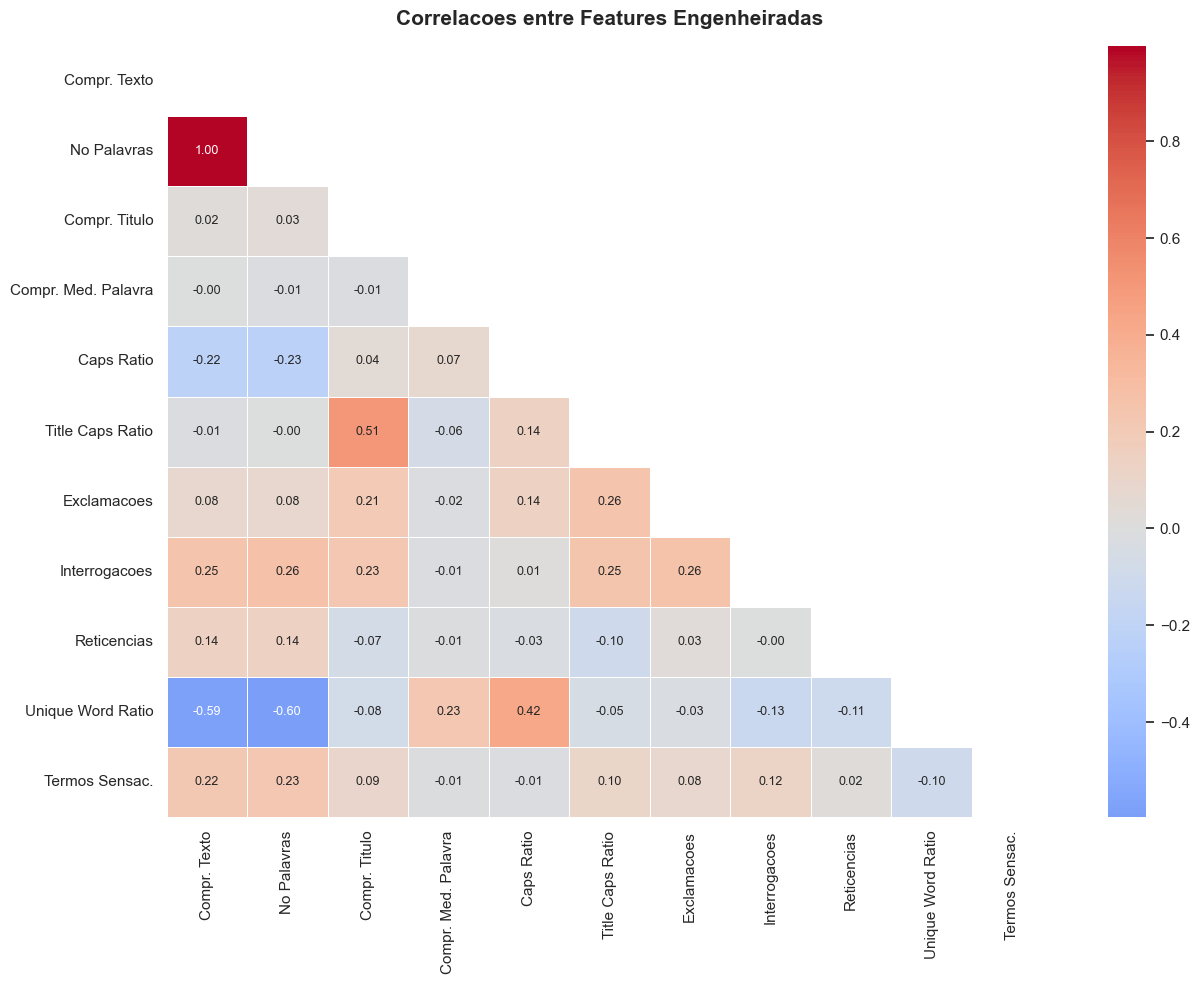

In [12]:
# Gráfico 5.1 — Heatmap de correlações de Pearson entre as 11 features de estilo
# Correlações > 0.7 indicam redundância; correlações próximas de 0 indicam independência
sns.set_theme(style='white')
FEAT_COLS = ['text_len','word_count','title_len','avg_word_len','caps_ratio',
             'title_caps_ratio','exclamation_count','question_count','ellipsis_count',
             'unique_word_ratio','sensational_count']
FEAT_LABELS = ['Compr. Texto','No Palavras','Compr. Titulo','Compr. Med. Palavra',
               'Caps Ratio','Title Caps Ratio','Exclamacoes','Interrogacoes',
               'Reticencias','Unique Word Ratio','Termos Sensac.']

corr = df[FEAT_COLS].corr()
corr.index = FEAT_LABELS
corr.columns = FEAT_LABELS

plt.figure(figsize=(13, 10))
sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)),
            annot=True, fmt='.2f', cmap='coolwarm', center=0,
            linewidths=0.5, annot_kws={'size': 9})
plt.title('Correlacoes entre Features Engenheiradas', fontsize=15, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

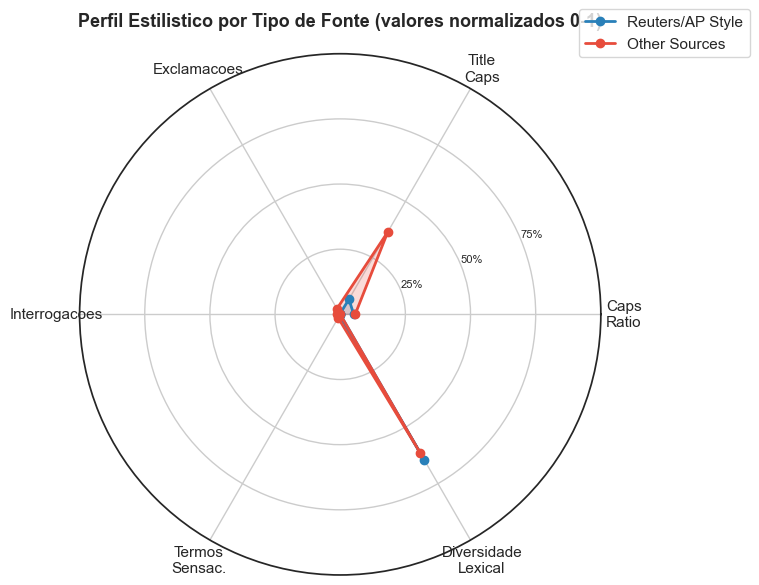

In [13]:
# Gráfico 5.2 — Radar: perfil médio normalizado de cada classe nas 6 features de estilo
# Normalização min-max para colocar todas as features na mesma escala [0, 1]
RADAR_FEATS  = ['caps_ratio','title_caps_ratio','exclamation_count',
                'question_count','sensational_count','unique_word_ratio']
RADAR_LABELS = ['Caps\nRatio','Title\nCaps','Exclamacoes',
                'Interrogacoes','Termos\nSensac.','Diversidade\nLexical']

df_norm = df[RADAR_FEATS].copy()
for col in RADAR_FEATS:
    mn, mx = df_norm[col].min(), df_norm[col].max()
    df_norm[col] = (df_norm[col] - mn) / (mx - mn + 1e-9)

angles = np.linspace(0, 2 * np.pi, len(RADAR_FEATS), endpoint=False).tolist() + [0]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})
for stype, color in PALETTE.items():
    vals = np.concatenate([df_norm[df['source_type'] == stype].mean().values, [0]])
    ax.plot(angles, vals, 'o-', lw=2, color=color, label=stype)
    ax.fill(angles, vals, alpha=0.2, color=color)

ax.set_thetagrids(np.degrees(angles[:-1]), RADAR_LABELS, fontsize=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.25, 0.5, 0.75])
ax.set_yticklabels(['25%','50%','75%'], fontsize=8)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.set_title('Perfil Estilistico por Tipo de Fonte (valores normalizados 0-1)',
             fontsize=13, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

> **Interpretação:**
>
> * **Independência das Features (Heatmap):** O mapa de calor confirma que as features de estilo são, em sua maioria, pouco correlacionadas entre si. A correlação mais alta esperada é entre `text_len` e `word_count` (redundância natural por serem medidas do mesmo texto em unidades diferentes), o que justifica manter apenas uma delas ou aceitar a redundância dado o baixo custo computacional.
>
> * **Perfil Radar - Separação Clara:** O gráfico radar é o resumo visual mais expressivo da análise. O polígono de `Other Sources` (fake news) apresenta área significativamente maior nas dimensões de `caps_ratio`, `exclamações` e `termos sensacionalistas`, enquanto o polígono de `Reuters/AP Style` se expande na dimensão de `diversidade lexical`. Isso confirma que as duas classes ocupam **regiões distintas** no espaço de features de estilo.
>
> * **Conclusão para Modelagem:** Todas as 15 features de estilo são válidas e complementares. Não há redundância severa que justifique eliminação. O conjunto completo será concatenado ao TF-IDF na pipeline final.

> **Decisão Técnica (Independência de Features):**
> A baixa correlação entre as features de pontuação/estilo e as features de diversidade atesta que o Feature Engineering captou dimensões independentes da desinformação. Todas as dimensões validadas no radar alimentam o dataset de entrada do modelo - cada uma contribuindo com sinal não redundante para a decisão do classificador.

## 6. Conclusão e Implicações para a Modelagem

Os três pilares fundamentais identificados são:

1. **Leakage e o Risco #1:** A assinatura "Reuters" está presente em 99%+ dos artigos de `politicsNews`/`worldnews`. A remoção via regex no pré-processamento é obrigatória - sem isso, o modelo aprende um atalho trivial ao invés de padrões linguísticos reais.

2. **Estilo como Discriminador Robusto:** As features de estilo - maiúsculas, pontuação excessiva, vocabulário sensacionalista e diversidade lexical - demonstram poder discriminativo claro e complementar ao conteúdo textual. A combinação das 15 features confere robustez ao classificador, especialmente em casos onde o conteúdo factual é ambíguo.

3. **TF-IDF com Trigramas Captura o Vocabulário Diagnóstico:** Padrões como "BREAKING:", "WATCH:", verbos de urgência e nomes políticos usados como anzol são melhor capturados com `ngram_range=(1,3)`. O vocabulário de 12.000 termos foi validado como suficiente para cobrir os padrões mais discriminativos.

---

**Próximos passos:** `notebook_01_preprocessing.ipynb` implementará a remoção de leakage, a extração das 15 features de estilo e a vetorização TF-IDF, com base direta nos achados desta análise.